In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Hidden Markov Model Assignment

The robot can move on the cells with light background, but cannot go over the obstacles, which have the dark blue background.

In [3]:
# Boolean representation of a random maze. True=feasible, False=obstacle.
# Use the maze corresponding to your group!
maze = np.ones((4, 16), dtype=bool)
rows, cols = 4, 16
obstacles = [11,12,13,14,19,21,23,25,27,30,35,39,48,49,50,51,52,53,55,59,62]
for cell in obstacles:
    r = cell // cols
    c = cell % cols
    maze[r][c] = False  # qui usiamo lista, non NumPy

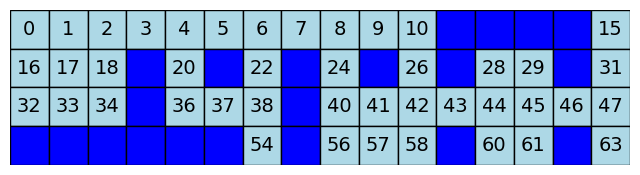

In [4]:
def plot_maze(ax, maze, skip_walls=True):
    cell_idx = 0
    rows, cols = maze.shape
    for r in range(rows):
        for c in range(cols):
            color = 'lightblue' if maze[r, c] == 1 else 'blue'
            ax.add_patch(patches.Rectangle((c, rows - 1 - r), 1, 1, edgecolor='black', facecolor=color))
            if maze[r, c] == 1 or not skip_walls:
                ax.text(c + 0.5, rows - 1 - r + 0.5, str(cell_idx), color='black', ha='center', va='center', fontsize=14)
            cell_idx += 1

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)


    ax.set_aspect('equal')
    ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 6))

plot_maze(ax, maze)

In [5]:
# Suggested names for possible states
rows, cols = maze.shape
states = [(r, c) for r in range(rows) for c in range(cols) if maze[r, c]]

states_with_idx = []
for r in range(rows):
    for c in range(cols):
        state = (r, c)  # Get the value (e.g., wall, open, etc.)
        # Store both index and value, regardless of state type
        states_with_idx.append(state) if maze[r, c] else states_with_idx.append(None)
        
states_with_idx

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 None,
 None,
 None,
 None,
 (0, 15),
 (1, 0),
 (1, 1),
 (1, 2),
 None,
 (1, 4),
 None,
 (1, 6),
 None,
 (1, 8),
 None,
 (1, 10),
 None,
 (1, 12),
 (1, 13),
 None,
 (1, 15),
 (2, 0),
 (2, 1),
 (2, 2),
 None,
 (2, 4),
 (2, 5),
 (2, 6),
 None,
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 None,
 None,
 None,
 None,
 None,
 None,
 (3, 6),
 None,
 (3, 8),
 (3, 9),
 (3, 10),
 None,
 (3, 12),
 (3, 13),
 None,
 (3, 15)]

In [6]:
# Suggested names for the possible observations. If can be seen as a binary digit from 0 to 15, where the least significant bit indicates West.
# This may be usefule to code the emission matrix
letters = ['N', 'S', 'E', 'W']
vocabulary = []
for i in range(2**len(letters)):  # observations can be indexed with numbers 0 to 15
    binary = format(i, '04b')  # 4-bit format interpreted as possibility to move N,S,E,W
    combination = ''.join([letters[j] for j in range(4) if binary[j] == '1'])
    vocabulary.append(combination)

In [7]:
vocabulary

['',
 'W',
 'E',
 'EW',
 'S',
 'SW',
 'SE',
 'SEW',
 'N',
 'NW',
 'NE',
 'NEW',
 'NS',
 'NSW',
 'NSE',
 'NSEW']

In [8]:
pi = np.zeros(cols*rows, dtype=float)
for i in range(len(pi)):
    pi[i] = 1/len(states) if states_with_idx[i] is not None else 0
pi

array([0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.        , 0.        , 0.        , 0.        ,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.        ,
       0.02325581, 0.        , 0.02325581, 0.        , 0.02325581,
       0.        , 0.02325581, 0.        , 0.02325581, 0.02325581,
       0.        , 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.        , 0.02325581, 0.02325581, 0.02325581, 0.        ,
       0.02325581, 0.02325581, 0.02325581, 0.02325581, 0.02325581,
       0.02325581, 0.02325581, 0.02325581, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02325581,
       0.        , 0.02325581, 0.02325581, 0.02325581, 0.        ,
       0.02325581, 0.02325581, 0.        , 0.02325581])

## 1 HMM Definition and Trajectory Generation

### 1.1 Transition probability definition

Define the *transition probability matrix* $A$ corresponding to the robot maze. Consider that:

* The robot can only reach a neighboring cell.
* The robot can move North, South, East, West.
* Diagonal moves are not allowed.
* Passing over obstacles is not allowed.
* Feasible transitions are equally probable.

In [9]:
def count_neighbours(states, state):
    count = 0
    neighbours = []
    if (state[0], state[1]-1) in states:
        count += 1
        neighbours.append((state[0], state[1]-1))
    if (state[0], state[1]+1) in states:
        count += 1
        neighbours.append((state[0], state[1]+1))
    if (state[0]-1, state[1]) in states:
        count += 1
        neighbours.append((state[0]-1, state[1]))
    if (state[0]+1, state[1]) in states:
        count += 1
        neighbours.append((state[0]+1, state[1]))
    return count, neighbours

In [10]:
A = np.zeros((rows*cols, rows*cols))
for state in states:
    count_neighbours_res = count_neighbours(states, (state[0],state[1]))
    for neighbour in count_neighbours_res[1]:
        A[states_with_idx.index((state[0],state[1])), neighbour[1] + neighbour[0]*cols] = 1 / count_neighbours_res[0]

for row in A:
    for val in row:
        print(f"{val:.2f}", end=" ")
    print()

0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.33 0.00 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.33 0.00 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.50 0.00 0.50 0.00 0.00 0.

### 1.2 Emission probability definition

Define the *emission probability matrix* $B$.
* After each move, the robot senses whether the cells to the North, South, East, West are feasible.
* There are 16 possible observations (previously defined variable `vocabulary`).

In [11]:
def vocabulary_counter(vocabulary, states):
    dict = {}
    for obs in vocabulary:
        dict[obs] = []
    for state in states:
        obs = ''
        if (state[0]-1, state[1]) in states:
            obs += 'N'
        if (state[0]+1, state[1]) in states:
            obs += 'S'
        if (state[0], state[1]+1) in states:
            obs += 'E'
        if (state[0], state[1]-1) in states:
            obs += 'W'
            
        dict[obs].append(state)
    
    return dict

In [12]:
B = np.zeros((rows*cols, len(vocabulary)))
dict = vocabulary_counter(vocabulary, states)
for voc in dict:
    for state in dict[voc]:
        B[state[0]*cols + state[1], vocabulary.index(voc)] = 1

for row in B:
    for val in row:
        print(f"{val:.2f}", end=" ")
    print()

0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.00 0.00 0.0

### 1.3 Trajectory Sampling

Sample and visualize a state and observation sequences $Z$ and $Y$ of
length $T = 20$ compatible with the previous hypotheses.

* Use the previously defined transition and emission matrices
* Consider the initial position equiprobable among the admissible states

In [13]:
def observation_given_state(state):
    obs = ''
    if (state[0]-1, state[1]) in states:
        obs += 'N'
    if (state[0]+1, state[1]) in states:
        obs += 'S'
    if (state[0], state[1]+1) in states:
        obs += 'E'
    if (state[0], state[1]-1) in states:
        obs += 'W'
    return obs

In [14]:
T = 20
Z = np.empty(shape=T, dtype=int)
Y = np.empty(shape=T, dtype=object)
indexes = [i for i in range(64)]

Z[0] = np.random.choice(indexes, p=pi)
for i in range(len(vocabulary)):
    if B[Z[0], i] == 1:
        Y[0] = vocabulary[i]
for i in range(1, T):
    Z[i] = np.random.choice(indexes,p=A[Z[i-1]])
    for j in range(len(vocabulary)):
        if B[Z[i], j] == 1:
            Y[i] = vocabulary[j]
print(Z)
print(Y)

[ 7  6 22  6  5  4  3  4  5  4 20  4  5  4 20 36 20 36 37 36]
['EW' 'SEW' 'NS' 'SEW' 'EW' 'SEW' 'EW' 'SEW' 'EW' 'SEW' 'NS' 'SEW' 'EW'
 'SEW' 'NS' 'NE' 'NS' 'NE' 'EW' 'NE']


## 2 Decoding and inference

### 2.1 Likelihood

Compute the likelihood of the obtained observation sequence $Y$.

In [15]:
N = rows*cols
alpha_all = np.zeros((T, N))

for t in range(T):
    for z_t in range(N):
        if t == 0:
            alpha_all[t, z_t] = pi[z_t] * B[z_t, vocabulary.index(Y[t])] 
        else:
            for z_prev in range(N):
                alpha_all[t, z_t] += alpha_all[t-1, z_prev] * A[z_prev, z_t] * B[z_t,  vocabulary.index(Y[t])]

#print(alpha_all)           
P_Y = np.sum(alpha_all[T-1, :])
P_Y

np.float64(6.697959533607679e-07)

### 2.1 Decoding 

Obtain the most probable state sequence, given the observation sequence $Y$.

In [16]:
v_all = np.empty((T, N))
bp_all = np.empty((T, N), dtype=int)

v_all[0] = pi * B[:, vocabulary.index(Y[0])]
for t in range(1, T):
    for j in range(N):
        prob = v_all[t - 1] * A[:, j]
        bp_all[t, j] = np.argmax(prob)
        v_all[t, j] = np.max(prob) * B[j, vocabulary.index(Y[t])]
        
# Backtracking
Z_vit = np.zeros(T, dtype=int)
Z_vit[T - 1] = np.argmax(v_all[T - 1]) # last step: just pick the argmax of v
for t in range(T - 2, -1, -1): # iterate backwards
    Z_vit[t] = bp_all[t + 1, Z_vit[t + 1]] 

Z_vit

[states_with_idx[z] for z in Z_vit]

[(0, 3),
 (0, 4),
 (1, 4),
 (0, 4),
 (0, 3),
 (0, 2),
 (0, 3),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 4),
 (0, 4),
 (0, 3),
 (0, 4),
 (1, 4),
 (2, 4),
 (1, 4),
 (2, 4),
 (2, 5),
 (2, 4)]

### 2.2 Filtering

Obtain the filtering distribution $P(z_t \mid y_{1:t})$ at each time step $t$.

### 2.3 Noisy observations

Repeat steps 2.1 and 2.2 in the presence of sensor error noise. In particular, consider that:
  * With probability $1-\epsilon$, the sensor provides the correct reading
  * With probability $\epsilon$, the sensor returns a wrong reading. 
  * The $\epsilon$ probability is equally split among all wrong readings.
  * Set $\epsilon=0.2$. Optionally, test also other values.

## 3 Analysis and discussion

Comment the techniques applied and the obtained results.